# Imports

In [13]:
import pandas as pd
from pathlib import Path
import numpy as np
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)


# User Configuration

In [ ]:
SAVE_DATA = True

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
# HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

SAMPLING_SIZE = None # Set None to use all data
RANDOM_SEED = 42

DATA_DIR = Path("../../data")
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="talk",
    palette="colorblind"
)

# Utility Functions

In [15]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

In [16]:
def prepare_data(df_real, df_synth, negative_control=False):
    df_real = df_real.copy()
    df_synth = df_synth.copy()
    df_combined = pd.concat([df_real, df_synth], ignore_index=True).reset_index(drop=True)

    if negative_control:
        df_combined['label'] = np.random.randint(0, 2, size=len(df_combined))
    else:
        df_combined.loc[:len(df_real)-1, 'label'] = 1
        df_combined.loc[len(df_real):,   'label'] = 0

    rng = np.random.default_rng(RANDOM_SEED)
    idx = rng.choice(df_combined.index,    size=len(df_real), replace=True)
    df_combined = df_combined.loc[idx].reset_index(drop=True)

    return df_combined

# Main Routine
## Datengrundlage

In [ ]:
df_real, df_synth, _ = load_data(
    REAL_FILE,
    SYNTH_FILE,
    data_dir=DATA_DIR
)

## Unique Kategorien für Encoder festhalten

In [18]:
df = prepare_data(df_real, df_synth)
print(df.dtypes)

num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols.remove('label')

cat_cols = df.select_dtypes(include=['category', 'bool']).columns.drop(
    ['consciousness_level','news_score']
).tolist()
ord_cols = ['consciousness_level','news_score']

icu_admission_24h          bool
age                       Int64
gender                 category
ethnicity              category
consciousness_level    category
temperature             float64
heart_rate                Int64
respiratory_rate          Int64
oxygen_saturation         Int64
systolic_bp               Int64
diastolic_bp              Int64
news_score             category
night_arrival              bool
weekend_arrival            bool
chief_complaint        category
icd_block              category
label                   float64
dtype: object


In [19]:
cat_categories = {
    col: sorted(df[col].dropna().unique().tolist())
    for col in cat_cols
}
ord_categories = {col: df[col].cat.categories.tolist() for col in ord_cols}

## (Optional) Sampling

In [ ]:
# if SAMPLING_SIZE is not None:
#     rng = np.random.default_rng(RANDOM_SEED)
#     idx_real    = rng.choice(df_real.index,    size=SAMPLING_SIZE, replace=True)
#     idx_synth   = rng.choice(df_synth.index,   size=SAMPLING_SIZE, replace=True)
#     idx_holdout = rng.choice(df_holdout.index, size=SAMPLING_SIZE, replace=True)

#     df_real    = df_real.loc[idx_real].reset_index(drop=True)
#     df_synth   = df_synth.loc[idx_synth].reset_index(drop=True)
#     df_holdout = df_holdout.loc[idx_holdout].reset_index(drop=True)

## Positiv-/Negativ-Kontrolle

In [21]:
# Negative Kontrolle (identische Datensätze)
df_negative_control = df_real.copy()
df_neg = prepare_data(df_real, df_negative_control, negative_control=True)

# Positive Kontrolle (stark manipulierte synthetische Daten)
df_positive_control = df_real.copy()
df_positive_control["age"] += np.random.normal(50, 10, size=len(df_positive_control)).round(0).astype(int)
df_positive_control["temperature"] += np.random.normal(6, 2, size=len(df_positive_control)).round(1)
df_pos = prepare_data(df_real, df_positive_control, negative_control=False)

# ML Logic
## Preprocessing: Features & Ziel trennen, Transformer bauen

In [22]:
def prepare_features(df, target: str='label'):
    """
    Gibt (preprocessor, X, y) zurück.
    Encoder: numerisch → StandardScaler,
             kategorial → OneHotEncoder(ignore_unknowns),
             ordinal → OrdinalEncoder.
    """
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

    df = df.copy()
    y = df[target]
    X = df.drop(columns=[target])

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(
                categories=[cat_categories[c] for c in cat_cols],
                handle_unknown='ignore',
                sparse_output=False
            ),
        cat_cols),
        ('ord', OrdinalEncoder(
                categories=[ord_categories[c] for c in ord_cols],
                handle_unknown='use_encoded_value',
                unknown_value=-1
            ),
        ord_cols)
    ], remainder="drop")

    return preprocessor, X, y

## Modelle definieren

In [ ]:
def define_models(rng_seed=RANDOM_SEED):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier

    return {
        'Logistic Regression': LogisticRegression(max_iter=500, random_state=rng_seed, n_jobs=-1),
        'KNN'                : KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        'Random Forest'      : RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=rng_seed,
            n_jobs=-1)
    }

## Einen Fold evaluieren

In [24]:
def evaluate_fold(pipe: Pipeline, X_train, y_train, X_test, y_test):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    return {
        'accuracy' : accuracy_score(y_test,   y_pred),
        'precision': precision_score(y_test,  y_pred),
        'recall'   : recall_score(y_test,    y_pred),
        'f1'       : f1_score(y_test,        y_pred),
        'roc_auc'  : roc_auc_score(y_test,   y_prob),
        'fpr'      : fpr,
        'tpr'      : tpr,
    }


## Cross-Validation laufen lassen

In [ ]:
def cross_validate_models(preprocessor, X, y, models, n_splits, random_state=RANDOM_SEED):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state) # entspricht train_test_split() für mehrfache, systematische Aufteilungen in K-Folds (hier für Cross-Validation)
    results = {name: [] for name in models}

    for name, model in models.items():
        print(f"\n== Model: {name} ==")
        for fold, (tr_idx, te_idx) in enumerate(cv.split(X, y), 1):
            print(f" Fold {fold}/{n_splits} …", end='')
            pipe = Pipeline([('pre', preprocessor), ('clf', model)])
            fold_res = evaluate_fold(pipe,
                                     X.iloc[tr_idx], y.iloc[tr_idx],
                                     X.iloc[te_idx], y.iloc[te_idx])
            results[name].append(fold_res)
            print(" done")
    return results


## Metriken zusammenfassen

In [26]:
def summarize_results(results):
    """
    Baut ein DataFrame mit Mean±SD für jede Metrik und jedes Modell.
    """
    rows = []
    for name, folds in results.items():
        stats = {}
        for metric in ['accuracy','precision','recall','f1','roc_auc']:
            vals = [f[metric] for f in folds]
            stats[f'{metric}_mean'] = np.mean(vals)
            stats[f'{metric}_sd']   = np.std(vals)
        rows.append({'Model': name, **stats})
    return pd.DataFrame(rows).set_index('Model')


In [27]:
def plot_mean_roc(results, n_splits, figsize=(10,8)):
    from itertools import cycle
    
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=figsize)
    # colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    colors = cycle(sns.color_palette("colorblind"))

    for name, folds in results.items():
        tprs, aucs = [], []
        for f in folds:
            interp_tpr = np.interp(mean_fpr, f['fpr'], f['tpr'])
            interp_tpr[0] = 0.
            tprs.append(interp_tpr)
            aucs.append(f['roc_auc'])

        mean_tpr = np.mean(tprs, axis=0)
        std_tpr  = np.std(tprs, axis=0)
        mean_auc = np.mean(aucs)
        std_auc  = np.std(aucs)
        c = next(colors)

        plt.plot(mean_fpr, mean_tpr,
                 label=f"{name} (AUC={mean_auc:.2f}±{std_auc:.2f})",
                 lw=2, color=c)
        plt.fill_between(mean_fpr,
                         np.maximum(mean_tpr - std_tpr, 0),
                         np.minimum(mean_tpr + std_tpr, 1),
                         color=c, alpha=0.2)

    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Mean ROC ± SD über {n_splits}-fach CV')
    plt.legend(loc='lower right')
    plt.tight_layout()


## Hauptfunktion

In [28]:
def evaluate_models_cv(df, target: str='label', output_name='ROC', n_splits=5, save_data=True, random_state: int=RANDOM_SEED):
    # Setup
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1) Features & Modelle
    pre, X, y    = prepare_features(df, target)
    models       = define_models()

    # 2) Cross-Validation
    results      = cross_validate_models(pre, X, y, models, n_splits)

    # 3) Zusammenfassen & Anzeigen
    df_summary   = summarize_results(results)
    display(df_summary)

    # 4) Speichern fold-wise (optional)
    if save_data:
        records = []
        for name, folds in results.items():
            for i, f in enumerate(folds, 1):
                rec = {'Model': name, 'Fold': i}
                rec.update({m: f[m] for m in ['accuracy','precision','recall','f1','roc_auc']})
                records.append(rec)
        pd.DataFrame(records).to_csv(OUTPUT_DIR_CSV /
            f'metrics_{output_name}_{timestamp}.csv',
            index=False, sep=';', decimal=',', encoding='utf-8'
        )

    # 5) ROC-Plot
    plot_mean_roc(results, n_splits)
    if save_data:
        plt.savefig(OUTPUT_DIR_FIG / f'ROC_{output_name}_{timestamp}.tiff',
                    dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    plt.show()


# 3. Anwendung
## 3.1 Proof-of-Concept-Test (POC-Test)
### 3.1.1 Negativ Control


== Model: Logistic Regression ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done

== Model: KNN ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done

== Model: Random Forest ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done


,accuracy_mean,accuracy_sd,precision_mean,precision_sd,recall_mean,recall_sd,f1_mean,f1_sd,roc_auc_mean,roc_auc_sd
Model,,,,,,,,,,
Logistic Regression,0.5358,0.003970,0.528257,0.004586,0.482644,0.015585,0.504262,0.008175,0.548980,0.007049
KNN,0.5680,0.008854,0.560280,0.009875,0.545979,0.014951,0.552921,0.009921,0.583151,0.006671
Random Forest,0.5704,0.004317,0.607904,0.018913,0.351067,0.042654,0.442863,0.028308,0.617924,0.003746


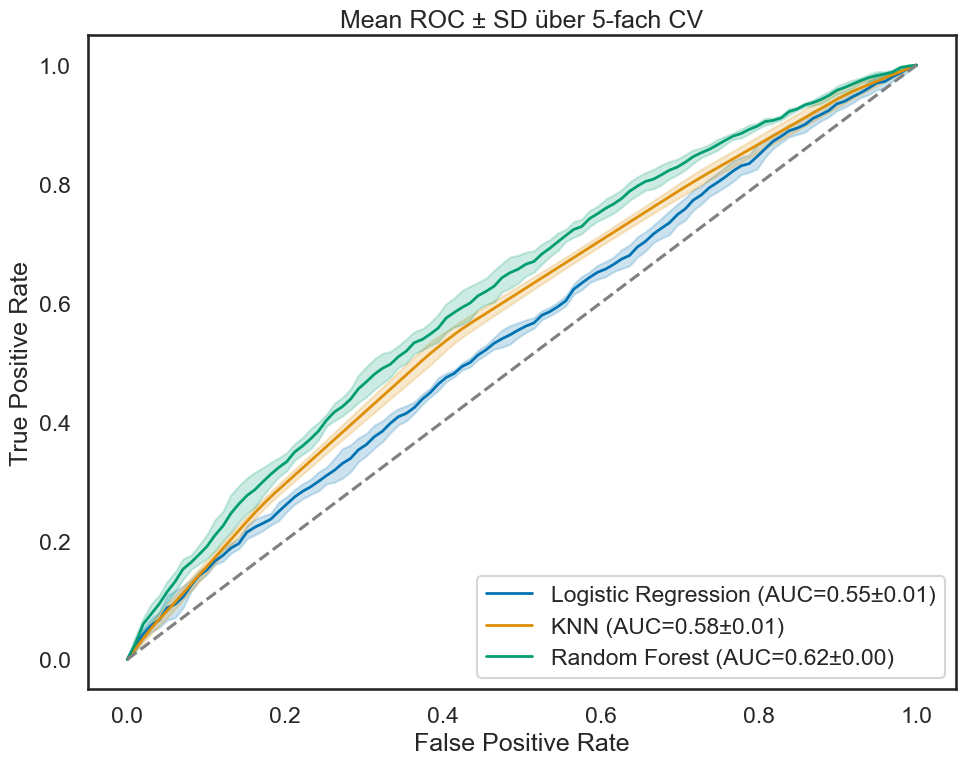

In [29]:
evaluate_models_cv(df_neg, output_name='negative_control', n_splits=5, save_data=SAVE_DATA, random_state=RANDOM_SEED)

### 3.1.2 Positiv Kontrolle


== Model: Logistic Regression ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done

== Model: KNN ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done

== Model: Random Forest ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done


,accuracy_mean,accuracy_sd,precision_mean,precision_sd,recall_mean,recall_sd,f1_mean,f1_sd,roc_auc_mean,roc_auc_sd
Model,,,,,,,,,,
Logistic Regression,0.9958,0.002400,0.992177,0.004774,0.999605,0.000791,0.995871,0.002356,0.999346,0.000701
KNN,0.9710,0.004147,0.957429,0.004364,0.986561,0.004575,0.971773,0.004039,0.991808,0.003403
Random Forest,0.9944,0.003007,0.992571,0.006273,0.996443,0.004220,0.994483,0.002949,0.999336,0.000662


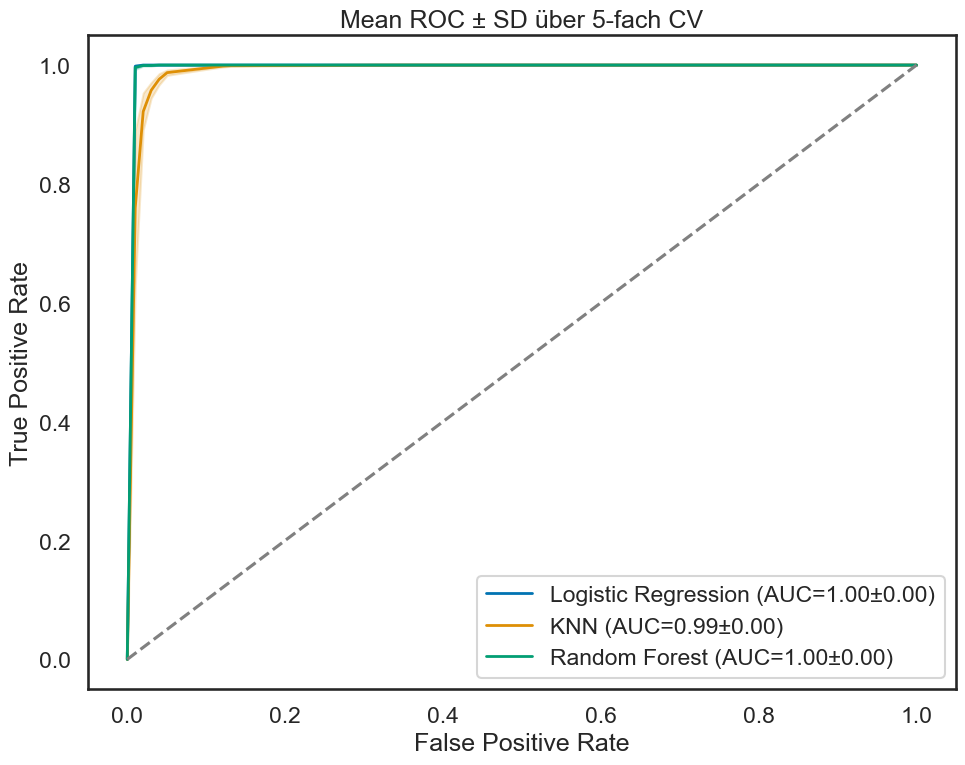

In [30]:
evaluate_models_cv(df_pos, output_name='positive_control', n_splits=5, save_data=SAVE_DATA, random_state=RANDOM_SEED)

## 3.2 Finale Analyse


== Model: Logistic Regression ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done

== Model: KNN ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done

== Model: Random Forest ==
 Fold 1/5 … done
 Fold 2/5 … done
 Fold 3/5 … done
 Fold 4/5 … done
 Fold 5/5 … done


,accuracy_mean,accuracy_sd,precision_mean,precision_sd,recall_mean,recall_sd,f1_mean,f1_sd,roc_auc_mean,roc_auc_sd
Model,,,,,,,,,,
Logistic Regression,0.672187,0.002027,0.670928,0.002309,0.674284,0.004728,0.672591,0.002529,0.732696,0.002630
KNN,0.797535,0.002182,0.779840,0.003134,0.828489,0.006247,0.803408,0.002553,0.873473,0.001055
Random Forest,0.744470,0.004668,0.738061,0.005704,0.757022,0.006333,0.747400,0.004490,0.823812,0.004593


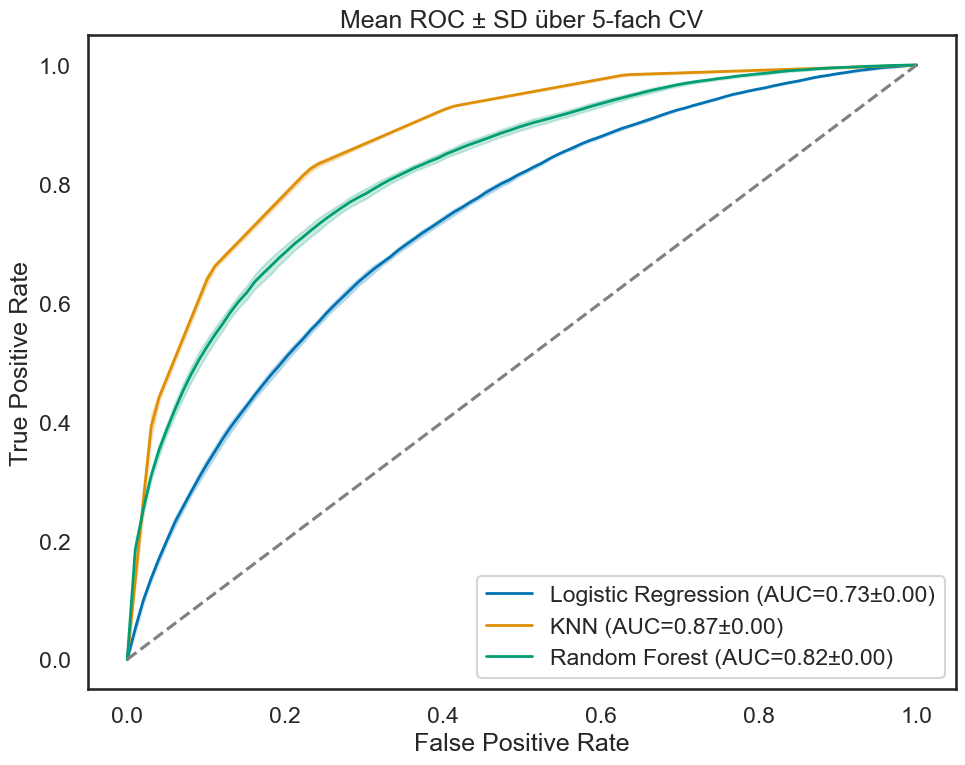

In [31]:

evaluate_models_cv(df, output_name='data', n_splits=5, save_data=SAVE_DATA, random_state=RANDOM_SEED)